In [ ]:
import os
import time
import numpy as np
import torch
from typing import Dict, List, Optional
import random
from config.default_config import Args
from agents.ppo_ import PPO
from environment.env_wrapper import EnvManager
from utils.logging_utils import Logger
from utils.evaluation_utils import evaluate_policy, run_episode
from matplotlib import pyplot as plt

In [2]:
args = Args()

In [3]:
def setup_experiment(args):
    """Set up experiment directory and logging."""
    # Create unique experiment name
    run_name = f"{args.exp_name}_{args.seed}_{int(time.time())}"
    
    # Set up working directory
    work_dir = os.path.join("runs", run_name)
    os.makedirs(work_dir, exist_ok=True)
    
    # Initialize logger
    logger = Logger(args, run_name, work_dir)
    
    # Set random seeds
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic
    
    return run_name, work_dir, logger
run_name, work_dir, logger = setup_experiment(args)
env_manager = EnvManager(args)
env = env_manager.create_single_env()
# remove the zeros from the reference solution
env.problem.reference_solution['temperatures'] = env.problem.reference_solution['temperatures'][env.problem.reference_solution['temperatures'] != 0]
plt.plot(env.problem.reference_solution['temperatures'])

In [34]:

# Initialize PPO agent
agent = PPO(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.n,
    lr_actor=args.learning_rate,
    lr_critic=args.learning_rate,
    gamma=args.gamma,
    K_epochs=args.update_epochs,
    eps_clip=args.clip_coef,
    has_continuous_action_space=False
)


# trained_model_path = "/Users/elotech/Documents/CODES/SCI-ML/intRL/ppo/runs/combustion_ppo_7_1741830754/checkpoint_50.pth"

# agent.load(trained_model_path)

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import time
from scipy.spatial.distance import cdist

def collect_data_with_vectorized_filtering(env, action, distance_threshold=0.1):
    """
    Collect data for a specific integrator action but only keep significantly different observations
    using vectorized operations for much faster filtering.
    
    Parameters:
    -----------
    env : gym.Env
        Environment to collect data from
    action : int
        Integrator action (0 for RK, 1 for BDF)
    distance_threshold : float
        L2 norm threshold for keeping an observation
        
    Returns:
    --------
    numpy.ndarray
        Filtered observation-action history
    float
        Total reward
    float
        Total error
    float
        Total CPU time
    float
        Total time reward
    float
        Total error reward
    """
    observation, info = env.reset()
    obs_action_history = []
    filtered_history = []
    done = False
    total_reward = 0
    total_error = 0
    total_time = 0
    total_time_reward = 0
    total_error_reward = 0
    
    # Initialize buffer for filtered observations (only the observation part)
    filtered_obs_buffer = np.empty((0, len(observation)))
    
    while not done:
        try:
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Store the complete information
            combined_info = np.concatenate((obs, [action], [reward], [info['error']], 
                                           [info['cpu_time']], [info['time_reward']], 
                                           [info['error_reward']]))
            
            # Check if observation is significantly different from all previous ones
            current_obs = obs.reshape(1, -1)  # Reshape for cdist
            
            if len(filtered_obs_buffer) > 0:
                # Calculate pairwise distances between current observation and all filtered observations
                distances = cdist(current_obs, filtered_obs_buffer, 'euclidean')[0]
                
                # If minimum distance exceeds threshold, keep the observation
                if np.min(distances) >= distance_threshold:
                    filtered_history.append(combined_info)
                    filtered_obs_buffer = np.vstack((filtered_obs_buffer, current_obs))
            else:
                # First observation is always kept
                filtered_history.append(combined_info)
                filtered_obs_buffer = np.vstack((filtered_obs_buffer, current_obs))
            
            # Always track total metrics
            obs_action_history.append(combined_info)
            total_reward += reward
            total_error += info['error']
            total_time += info['cpu_time']
            total_time_reward += info['time_reward']
            total_error_reward += info['error_reward']
            
        except Exception as e:
            print(f"Exception during data collection: {e}")
            done = True
    
    if len(obs_action_history) > 0:
        print(f"Kept {len(filtered_history)} out of {len(obs_action_history)} observations "
              f"({100 * len(filtered_history) / len(obs_action_history):.2f}%)")
    
    return np.array(filtered_history) if filtered_history else np.empty((0, len(combined_info) if 'combined_info' in locals() else 0)), \
           total_reward, total_error, total_time, total_time_reward, total_error_reward


def combine_optimal_data_vectorized(rk_history, bdf_history, metric='reward', distance_threshold=0.1):
    """
    Combine data from RK and BDF integrators using vectorized operations,
    keeping only the observations where the chosen metric is optimal.
    
    Parameters:
    -----------
    rk_history : numpy.ndarray
        History data from RK integrator, shape (timesteps, features)
    bdf_history : numpy.ndarray
        History data from BDF integrator, shape (timesteps, features)
    metric : str
        Metric to use for selection: 'reward', 'error', 'cpu_time', 'time_reward', 'error_reward'
    distance_threshold : float
        L2 norm threshold for considering observations as similar
        
    Returns:
    --------
    numpy.ndarray
        Combined history with optimal entries based on metric
    numpy.ndarray
        Integrator choice for each timestep (0 for RK, 1 for BDF)
    dict
        Statistics about integrator usage
    """
    # Handle empty cases
    if len(rk_history) == 0 and len(bdf_history) == 0:
        return np.array([]), np.array([]), {"error": "Both histories are empty"}
    
    if len(rk_history) == 0:
        # Only BDF data is available
        obs_dim = bdf_history.shape[1] - 6
        combined_history = bdf_history
        integrator_choices = np.ones(len(bdf_history), dtype=int)
        
        stats = {
            'rk_usage_percentage': 0.0,
            'bdf_usage_percentage': 100.0,
            'total_timesteps': len(bdf_history),
            'rk_timesteps': 0,
            'bdf_timesteps': len(bdf_history)
        }
        return combined_history, integrator_choices, stats
    
    if len(bdf_history) == 0:
        # Only RK data is available
        obs_dim = rk_history.shape[1] - 6
        combined_history = rk_history
        integrator_choices = np.zeros(len(rk_history), dtype=int)
        
        stats = {
            'rk_usage_percentage': 100.0,
            'bdf_usage_percentage': 0.0,
            'total_timesteps': len(rk_history),
            'rk_timesteps': len(rk_history),
            'bdf_timesteps': 0
        }
        return combined_history, integrator_choices, stats
    
    # Both histories have data
    # Extract dimensions and metric indices
    obs_dim = min(rk_history.shape[1], bdf_history.shape[1]) - 6
    
    metric_indices = {
        'reward': obs_dim + 1,
        'error': obs_dim + 2,
        'cpu_time': obs_dim + 3,
        'time_reward': obs_dim + 4,
        'error_reward': obs_dim + 5,
    }
    
    if metric not in metric_indices:
        raise ValueError(f"Unknown metric: {metric}")
    
    # For negative metrics (like error, cpu_time), we want to minimize
    negative_metrics = ['error', 'cpu_time']
    idx = metric_indices[metric]
    error_idx = metric_indices['error']
    error_threshold = 1e-3  # Error threshold for deciding BDF is better
    
    # Extract observations for distance calculations
    rk_obs = rk_history[:, :obs_dim]
    bdf_obs = bdf_history[:, :obs_dim]
    
    # Calculate all pairwise distances between RK and BDF observations
    # This is the most computationally intensive part, but it's vectorized
    print("Calculating pairwise distances between RK and BDF observations...")
    start_time = time.time()
    distances = cdist(rk_obs, bdf_obs, 'euclidean')
    print(f"Distance calculation completed in {time.time() - start_time:.2f} seconds")
    
    # Find nearest BDF observation for each RK observation
    min_distances = np.min(distances, axis=1)
    nearest_bdf_indices = np.argmin(distances, axis=1)
    
    # Determine which observations have a close match
    has_match_mask = min_distances < distance_threshold
    
    # Initialize arrays for combined history
    combined_entries = []
    processed_bdf_indices = set()
    
    # Process RK observations with matches to BDF
    for i, has_match in enumerate(has_match_mask):
        if has_match:
            bdf_idx = nearest_bdf_indices[i]
            processed_bdf_indices.add(bdf_idx)
            
            # Compare metrics to decide which is better
            rk_metric_value = rk_history[i, idx]
            bdf_metric_value = bdf_history[bdf_idx, idx]
            
            rk_error = rk_history[i, error_idx]
            bdf_error = bdf_history[bdf_idx, error_idx]
            
            # Determine which is better
            if metric in negative_metrics:
                is_bdf_better = bdf_metric_value < rk_metric_value
            else:
                is_bdf_better = bdf_metric_value > rk_metric_value
            
            # Special case: If RK error is above threshold and BDF error is below, prefer BDF
            if rk_error >= error_threshold and bdf_error <= error_threshold:
                is_bdf_better = True
            
            if is_bdf_better:
                combined_entries.append(bdf_history[bdf_idx])
            else:
                combined_entries.append(rk_history[i])
        else:
            # No close match, keep RK observation
            combined_entries.append(rk_history[i])
    
    # Add remaining BDF observations that weren't matched
    remaining_bdf_indices = [i for i in range(len(bdf_history)) if i not in processed_bdf_indices]
    
    # For remaining BDF entries, check if they're far enough from all combined entries so far
    if combined_entries:
        combined_obs = np.array([entry[:obs_dim] for entry in combined_entries])
        
        for i in remaining_bdf_indices:
            bdf_entry_obs = bdf_history[i, :obs_dim].reshape(1, -1)
            
            # Calculate distances to existing combined observations
            entry_distances = cdist(bdf_entry_obs, combined_obs, 'euclidean')[0]
            
            # If minimum distance exceeds threshold, it's a unique observation
            if np.min(entry_distances) >= distance_threshold:
                combined_entries.append(bdf_history[i])
    else:
        # No combined entries yet, add all remaining BDF entries
        for i in remaining_bdf_indices:
            combined_entries.append(bdf_history[i])
    
    # Convert to numpy array
    if combined_entries:
        combined_history = np.array(combined_entries)
        
        # Extract the actions to determine integrator choices
        integrator_choices = combined_history[:, obs_dim].astype(int)
        
        # Calculate statistics
        rk_count = np.sum(integrator_choices == 0)
        bdf_count = np.sum(integrator_choices == 1)
        total_count = len(integrator_choices)
        
        stats = {
            'rk_usage_percentage': 100 * rk_count / total_count if total_count > 0 else 0,
            'bdf_usage_percentage': 100 * bdf_count / total_count if total_count > 0 else 0,
            'total_timesteps': total_count,
            'rk_timesteps': rk_count,
            'bdf_timesteps': bdf_count,
            'original_rk_count': len(rk_history),
            'original_bdf_count': len(bdf_history),
            'reduction_percentage': 100 * (1 - total_count / (len(rk_history) + len(bdf_history)))
        }
        
        return combined_history, integrator_choices, stats
    else:
        return np.array([]), np.array([]), {"error": "No entries matched criteria"}


def collect_optimal_data_online_vectorized(env_manager, metric='reward', num_episodes=10, 
                                           distance_threshold=0.1, verbose=True):
    """
    Collect data using vectorized operations for filtering similar observations.
    
    Parameters:
    -----------
    env_manager : EnvManager
        Environment manager to create environments
    metric : str
        Metric to use for selection: 'reward', 'error', 'cpu_time', 'time_reward', 'error_reward'
    num_episodes : int
        Number of episodes to collect
    distance_threshold : float
        L2 norm threshold for keeping an observation
    verbose : bool
        Whether to print detailed progress information
        
    Returns:
    --------
    list
        List of combined history arrays
    dict
        Overall statistics
    """
    all_combined_history = []
    overall_stats = {
        'total_rk_timesteps': 0,
        'total_bdf_timesteps': 0,
        'total_original_observations': 0,
        'total_filtered_observations': 0,
        'episodes_completed': 0,
        'computation_time': 0
    }
    
    start_time = time.time()
    
    for episode in tqdm(range(num_episodes), desc="Collecting filtered optimal data"):
        if verbose:
            print(f"\nCollecting data for episode {episode+1}/{num_episodes}")
        
        try:
            episode_start = time.time()
            
            # Create a new environment for each episode
            env = env_manager.create_single_env()
            
            # Collect data for both integrators with filtering
            rk_history, rk_reward, rk_error, rk_time, rk_time_reward, rk_error_reward = collect_data_with_vectorized_filtering(
                env, 0, distance_threshold=distance_threshold
            )
            
            bdf_history, bdf_reward, bdf_error, bdf_time, bdf_time_reward, bdf_error_reward = collect_data_with_vectorized_filtering(
                env, 1, distance_threshold=distance_threshold
            )
            
            # Combine data keeping only the optimal integrator for each observation
            combined_history, integrator_choices, stats = combine_optimal_data_vectorized(
                rk_history=rk_history,
                bdf_history=bdf_history,
                metric=metric,
                distance_threshold=distance_threshold
            )
            
            # Calculate episode time
            episode_time = time.time() - episode_start
            overall_stats['computation_time'] += episode_time
            
            # Update overall statistics
            overall_stats['total_rk_timesteps'] += stats.get('rk_timesteps', 0)
            overall_stats['total_bdf_timesteps'] += stats.get('bdf_timesteps', 0)
            overall_stats['total_filtered_observations'] += len(combined_history)
            overall_stats['total_original_observations'] += stats.get('original_rk_count', 0) + stats.get('original_bdf_count', 0)
            overall_stats['episodes_completed'] += 1
            
            # Print episode stats
            if verbose or episode % 10 == 0:
                rk_count = stats.get('rk_timesteps', 0)
                bdf_count = stats.get('bdf_timesteps', 0)
                print(f"Episode {episode+1} results ({episode_time:.2f}s):")
                print(f"  Original observations: RK={stats.get('original_rk_count', 0)}, BDF={stats.get('original_bdf_count', 0)}")
                print(f"  Unique observations after filtering: {len(combined_history)}")
                print(f"  Reduction: {stats.get('reduction_percentage', 0):.1f}%")
                print(f"  Final distribution: RK={rk_count} ({stats.get('rk_usage_percentage', 0):.1f}%), "
                      f"BDF={bdf_count} ({stats.get('bdf_usage_percentage', 0):.1f}%)")
            
            # Add to collection
            if len(combined_history) > 0:
                all_combined_history.append(combined_history)
        
        except Exception as e:
            print(f"Error in episode {episode+1}: {e}")
    
    # Calculate final statistics
    elapsed_time = time.time() - start_time
    all_observations = 0
    if all_combined_history:
        all_observations = sum(len(history) for history in all_combined_history)
    
    overall_stats['total_observations'] = all_observations
    overall_stats['collection_time'] = elapsed_time
    overall_stats['computation_percentage'] = 100 * overall_stats['computation_time'] / elapsed_time if elapsed_time > 0 else 0
    overall_stats['observations_per_second'] = all_observations / elapsed_time if elapsed_time > 0 else 0
    overall_stats['average_observations_per_episode'] = all_observations / overall_stats['episodes_completed'] if overall_stats['episodes_completed'] > 0 else 0
    
    total_timesteps = overall_stats['total_rk_timesteps'] + overall_stats['total_bdf_timesteps']
    if total_timesteps > 0:
        overall_stats['final_rk_percentage'] = 100 * overall_stats['total_rk_timesteps'] / total_timesteps
        overall_stats['final_bdf_percentage'] = 100 * overall_stats['total_bdf_timesteps'] / total_timesteps
    
    if overall_stats['total_original_observations'] > 0:
        overall_stats['total_reduction_percentage'] = 100 * (1 - all_observations / overall_stats['total_original_observations'])
    
    # Print overall stats
    print("\nData collection complete!")
    print(f"Collected {all_observations} unique observations from {overall_stats['episodes_completed']} episodes")
    print(f"Total original observations: {overall_stats['total_original_observations']}")
    print(f"Reduction: {overall_stats.get('total_reduction_percentage', 0):.1f}%")
    print(f"RK usage: {overall_stats['total_rk_timesteps']} timesteps ({overall_stats.get('final_rk_percentage', 0):.1f}%)")
    print(f"BDF usage: {overall_stats['total_bdf_timesteps']} timesteps ({overall_stats.get('final_bdf_percentage', 0):.1f}%)")
    print(f"Total time: {elapsed_time:.1f}s (computation: {overall_stats['computation_time']:.1f}s, {overall_stats['computation_percentage']:.1f}%)")
    print(f"Processing speed: {overall_stats['observations_per_second']:.1f} obs/sec")
    
    return all_combined_history, overall_stats


# Example usage:
if __name__ == "__main__":
    # Import environment manager
    from environment.env_wrapper import EnvManager
    from config.default_config import Args
    
    # Initialize environment manager
    args = Args()
    env_manager = EnvManager(args, single_env=True)
    
    # Collect filtered optimal data with vectorized operations
    filtered_data, stats = collect_optimal_data_online_vectorized(
        env_manager=env_manager,
        metric='reward',  # Use 'reward', 'error', 'cpu_time', etc.
        num_episodes=100,
        distance_threshold=0.001  # Adjust this threshold based on your observation space
    )
    


In [203]:
# Concatenate all episodes
if filtered_data:
    pretraining_dataset = np.concatenate(filtered_data, axis=0)
    print(f"Final dataset shape: {pretraining_dataset.shape}")
    
    # Save the dataset
    np.save('pretraining_dataset_filtered.npy', pretraining_dataset)
    print("Dataset saved to 'pretraining_dataset_filtered.npy'")
else:
    print("No data collected.")

Final dataset shape: (30036, 16)
Dataset saved to 'pretraining_dataset_filtered.npy'


In [211]:
# check the action distribution
print(np.unique(pretraining_dataset[:, 10], return_counts=True))


(array([0., 1.]), array([19330, 10706]))


In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

class IntegratorDataset(Dataset):
    """Dataset for pretraining the PPO actor with optimal integrator choices."""
    
    def __init__(self, data, obs_dim):
        """
        Initialize dataset from collected optimal integrator data.
        
        Parameters:
        -----------
        data : numpy.ndarray
            Combined history data with structure: [obs, action, reward, error, cpu_time, time_reward, error_reward]
        obs_dim : int
            Dimension of the observation space
        """
        self.data = data
        self.obs_dim = obs_dim
        
        # CHECK the distribution of the actions
        print(np.unique(data[:, obs_dim], return_counts=True))
        
        # Extract observations and actions from the combined data
        self.states = data[:, :obs_dim]
        self.actions = data[:, obs_dim].astype(np.int64)  # Extract actions (already 0 or 1)
        
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]


def pretrain_ppo_actor(agent, dataset_path, obs_dim, batch_size=64, epochs=10, 
                       learning_rate=1e-4, save_path=None, device=None):
    """
    Pretrain the PPO actor network using supervised learning on optimal integrator data.
    
    Parameters:
    -----------
    agent : PPO
        The PPO agent with actor network to be pretrained
    dataset_path : str
        Path to the numpy array containing the pretraining dataset
    obs_dim : int
        Dimension of the observation space
    batch_size : int
        Batch size for training
    epochs : int
        Number of epochs to train
    learning_rate : float
        Learning rate for the optimizer
    save_path : str, optional
        Path to save the pretrained model (if None, doesn't save)
    device : torch.device, optional
        Device to use for training (if None, uses agent's device)
        
    Returns:
    --------
    list
        Training loss history
    """
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Load dataset
    print(f"Loading dataset from {dataset_path}")
    data = np.load(dataset_path)
    print(f"Dataset shape: {data.shape}")
    
    # Create dataset and dataloader
    integrator_dataset = IntegratorDataset(data, obs_dim)
    dataloader = DataLoader(integrator_dataset, batch_size=batch_size, shuffle=True)
    
    # Extract the actor network from the agent
    actor = agent.policy.actor
    actor.to(device)
    actor.train()
    
    # Setup optimizer and loss function
    optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    loss_history = []
    
    print(f"Starting pretraining for {epochs} epochs")
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        
        for states, actions in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            states = states.float().to(device)
            actions = actions.to(device)
            
            # Forward pass
            action_probs = actor(states)
            loss = criterion(action_probs, actions)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(action_probs.data, 1)
            total += actions.size(0)
            correct += (predicted == actions).sum().item()
            
            epoch_loss += loss.item()
        
        # Calculate average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(dataloader)
        accuracy = 100 * correct / total
        loss_history.append(avg_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save pretrained model if path is provided
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(actor.state_dict(), save_path)
        print(f"Pretrained model saved to {save_path}")
    
    return loss_history


def load_pretrained_actor(agent, pretrained_path, device=None):
    """
    Load pretrained weights into the PPO actor network.
    
    Parameters:
    -----------
    agent : PPO
        The PPO agent to load pretrained weights into
    pretrained_path : str
        Path to the pretrained model weights
    device : torch.device, optional
        Device to load the model to
    """
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Load pretrained weights
    state_dict = torch.load(pretrained_path, map_location=device)
    
    # Load weights into both policy and policy_old actors
    agent.policy.actor.load_state_dict(state_dict)
    agent.policy_old.actor.load_state_dict(state_dict)
    
    print(f"Loaded pretrained actor weights from {pretrained_path}")


def plot_pretraining_results(loss_history, save_path=None):
    """
    Plot training loss history.
    
    Parameters:
    -----------
    loss_history : list
        List of loss values per epoch
    save_path : str, optional
        Path to save the plot
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, marker='o')
    plt.title('Pretraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    
    plt.show()


def evaluate_pretrained_policy(agent, env, num_episodes=5, render=False):
    """
    Evaluate the pretrained policy.
    
    Parameters:
    -----------
    agent : PPO
        The PPO agent with pretrained actor
    env : gym.Env
        Environment to evaluate in
    num_episodes : int
        Number of episodes to evaluate
    render : bool
        Whether to render the environment
        
    Returns:
    --------
    dict
        Evaluation statistics
    """
    total_rewards = []
    action_distribution = {0: 0, 1: 0}  # 0 for RK, 1 for BDF
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            # Use deterministic policy (argmax) for evaluation
            action = agent.select_action(obs, deterministic=True, store_in_buffer=False)
            action_distribution[action] += 1
            
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            
            if render:
                env.render()
        
        total_rewards.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward:.2f}")
    
    # Calculate statistics
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    total_actions = sum(action_distribution.values())
    action_percentages = {k: (v / total_actions) * 100 for k, v in action_distribution.items()}
    
    stats = {
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'min_reward': np.min(total_rewards),
        'max_reward': np.max(total_rewards),
        'action_distribution': action_distribution,
        'action_percentages': action_percentages
    }
    
    print(f"\nEvaluation Results (over {num_episodes} episodes):")
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"Action Distribution: RK = {action_percentages[0]:.1f}%, BDF = {action_percentages[1]:.1f}%")
    
    return stats




Combustion problem initialized with T=1400.0, P=101325.0, phi=0.7 and timestep=1e-06


Computing reference solution: 100%|██████████| 2000/2000 [00:00<00:00, 12030.42it/s]


Reference solution computed in 0.17 seconds
Environment 0 created with T=1400.0, P=101325.0, phi=0.7 and timestep=1e-06
Combustion problem initialized with T=500.0, P=101325.0, phi=0.7999999999999999 and timestep=0.001


Computing reference solution: 100%|██████████| 50/50 [00:00<00:00, 10429.96it/s]


Reference solution computed in 0.01 seconds
Using device: cpu
Loading dataset from pretraining_dataset_filtered.npy
Dataset shape: (30036, 16)

Action distribution in train set:
  Action 0: 15463 samples (64.35%)
  Action 1: 8565 samples (35.65%)

Action distribution in test set:
  Action 0: 3867 samples (64.36%)
  Action 1: 2141 samples (35.64%)

Train set: 24028 samples (80.0%)
Test set: 6008 samples (20.0%)
Action distribution in dataset:
  Action 0: 15463 samples (64.35%)
  Action 1: 8565 samples (35.65%)
Action distribution in dataset:
  Action 0: 3867 samples (64.36%)
  Action 1: 2141 samples (35.64%)
Starting pretraining for up to 50 epochs with early stopping (patience=7)


Epoch 1/50
  Train Loss: 0.6332, Train Accuracy: 65.09%
  Test Loss: 0.6113, Test Accuracy: 69.04%
  New best model! (Test Loss: 0.6113)


Epoch 2/50
  Train Loss: 0.5990, Train Accuracy: 70.26%
  Test Loss: 0.5856, Test Accuracy: 73.17%
  New best model! (Test Loss: 0.5856)


Epoch 3/50
  Train Loss: 0.5871, Train Accuracy: 72.05%
  Test Loss: 0.5775, Test Accuracy: 73.25%
  New best model! (Test Loss: 0.5775)


Epoch 4/50
  Train Loss: 0.5822, Train Accuracy: 72.62%
  Test Loss: 0.5738, Test Accuracy: 73.55%
  New best model! (Test Loss: 0.5738)


Epoch 5/50
  Train Loss: 0.5784, Train Accuracy: 72.73%
  Test Loss: 0.5758, Test Accuracy: 72.90%
  No improvement for 1 epochs. Best Test Loss: 0.5738 at epoch 4


Epoch 6/50
  Train Loss: 0.5767, Train Accuracy: 72.81%
  Test Loss: 0.5755, Test Accuracy: 73.04%
  No improvement for 2 epochs. Best Test Loss: 0.5738 at epoch 4


Epoch 7/50
  Train Loss: 0.5768, Train Accuracy: 72.94%
  Test Loss: 0.5720, Test Accuracy: 73.50%
  New best model! (Test Loss: 0.5720)


Epoch 8/50
  Train Loss: 0.5757, Train Accuracy: 73.09%
  Test Loss: 0.5680, Test Accuracy: 74.02%
  New best model! (Test Loss: 0.5680)


Epoch 9/50
  Train Loss: 0.5755, Train Accuracy: 72.99%
  Test Loss: 0.5672, Test Accuracy: 74.08%
  New best model! (Test Loss: 0.5672)


Epoch 10/50
  Train Loss: 0.5751, Train Accuracy: 73.16%
  Test Loss: 0.5663, Test Accuracy: 74.27%
  New best model! (Test Loss: 0.5663)


Epoch 11/50
  Train Loss: 0.5749, Train Accuracy: 73.21%
  Test Loss: 0.5669, Test Accuracy: 74.38%
  No improvement for 1 epochs. Best Test Loss: 0.5663 at epoch 10


Epoch 12/50
  Train Loss: 0.5746, Train Accuracy: 73.31%
  Test Loss: 0.5688, Test Accuracy: 73.74%
  No improvement for 2 epochs. Best Test Loss: 0.5663 at epoch 10


Epoch 13/50
  Train Loss: 0.5744, Train Accuracy: 73.30%
  Test Loss: 0.5677, Test Accuracy: 73.98%
  No improvement for 3 epochs. Best Test Loss: 0.5663 at epoch 10


Epoch 14/50
  Train Loss: 0.5744, Train Accuracy: 73.32%
  Test Loss: 0.5661, Test Accuracy: 74.53%
  New best model! (Test Loss: 0.5661)


Epoch 15/50
  Train Loss: 0.5738, Train Accuracy: 73.35%
  Test Loss: 0.5657, Test Accuracy: 74.18%
  New best model! (Test Loss: 0.5657)


Epoch 16/50
  Train Loss: 0.5732, Train Accuracy: 73.41%
  Test Loss: 0.5677, Test Accuracy: 73.78%
  No improvement for 1 epochs. Best Test Loss: 0.5657 at epoch 15


Epoch 17/50
  Train Loss: 0.5745, Train Accuracy: 73.28%
  Test Loss: 0.5648, Test Accuracy: 74.27%
  New best model! (Test Loss: 0.5648)


Epoch 18/50
  Train Loss: 0.5728, Train Accuracy: 73.49%
  Test Loss: 0.5697, Test Accuracy: 73.55%
  No improvement for 1 epochs. Best Test Loss: 0.5648 at epoch 17


Epoch 19/50
  Train Loss: 0.5733, Train Accuracy: 73.34%
  Test Loss: 0.5654, Test Accuracy: 74.08%
  No improvement for 2 epochs. Best Test Loss: 0.5648 at epoch 17


Epoch 20/50
  Train Loss: 0.5729, Train Accuracy: 73.55%
  Test Loss: 0.5642, Test Accuracy: 74.25%
  New best model! (Test Loss: 0.5642)


Epoch 21/50
  Train Loss: 0.5725, Train Accuracy: 73.41%
  Test Loss: 0.5648, Test Accuracy: 74.15%
  No improvement for 1 epochs. Best Test Loss: 0.5642 at epoch 20


Epoch 22/50
  Train Loss: 0.5720, Train Accuracy: 73.48%
  Test Loss: 0.5661, Test Accuracy: 74.12%
  No improvement for 2 epochs. Best Test Loss: 0.5642 at epoch 20


Epoch 23/50
  Train Loss: 0.5717, Train Accuracy: 73.60%
  Test Loss: 0.5644, Test Accuracy: 74.63%
  No improvement for 3 epochs. Best Test Loss: 0.5642 at epoch 20


Epoch 24/50
  Train Loss: 0.5719, Train Accuracy: 73.47%
  Test Loss: 0.5626, Test Accuracy: 74.50%
  New best model! (Test Loss: 0.5626)


Epoch 25/50
  Train Loss: 0.5708, Train Accuracy: 73.59%
  Test Loss: 0.5621, Test Accuracy: 74.52%
  New best model! (Test Loss: 0.5621)


Epoch 26/50
  Train Loss: 0.5705, Train Accuracy: 73.61%
  Test Loss: 0.5660, Test Accuracy: 73.77%
  No improvement for 1 epochs. Best Test Loss: 0.5621 at epoch 25


Epoch 27/50
  Train Loss: 0.5701, Train Accuracy: 73.62%
  Test Loss: 0.5616, Test Accuracy: 74.60%
  New best model! (Test Loss: 0.5616)


Epoch 28/50
  Train Loss: 0.5687, Train Accuracy: 73.77%
  Test Loss: 0.5591, Test Accuracy: 74.92%
  New best model! (Test Loss: 0.5591)


Epoch 29/50
  Train Loss: 0.5677, Train Accuracy: 73.97%
  Test Loss: 0.5584, Test Accuracy: 75.13%
  New best model! (Test Loss: 0.5584)


Epoch 30/50
  Train Loss: 0.5664, Train Accuracy: 74.03%
  Test Loss: 0.5612, Test Accuracy: 74.32%
  No improvement for 1 epochs. Best Test Loss: 0.5584 at epoch 29


Epoch 31/50
  Train Loss: 0.5657, Train Accuracy: 74.03%
  Test Loss: 0.5604, Test Accuracy: 74.83%
  No improvement for 2 epochs. Best Test Loss: 0.5584 at epoch 29


Epoch 32/50
  Train Loss: 0.5641, Train Accuracy: 74.21%
  Test Loss: 0.5549, Test Accuracy: 75.58%
  New best model! (Test Loss: 0.5549)


Epoch 33/50
  Train Loss: 0.5633, Train Accuracy: 74.32%
  Test Loss: 0.5548, Test Accuracy: 75.47%
  New best model! (Test Loss: 0.5548)


Epoch 34/50
  Train Loss: 0.5614, Train Accuracy: 74.42%
  Test Loss: 0.5516, Test Accuracy: 75.38%
  New best model! (Test Loss: 0.5516)


Epoch 35/50
  Train Loss: 0.5596, Train Accuracy: 74.55%
  Test Loss: 0.5519, Test Accuracy: 75.63%
  No improvement for 1 epochs. Best Test Loss: 0.5516 at epoch 34


Epoch 36/50
  Train Loss: 0.5585, Train Accuracy: 74.70%
  Test Loss: 0.5502, Test Accuracy: 75.48%
  New best model! (Test Loss: 0.5502)


Epoch 37/50
  Train Loss: 0.5570, Train Accuracy: 74.70%
  Test Loss: 0.5492, Test Accuracy: 76.05%
  New best model! (Test Loss: 0.5492)


Epoch 38/50
  Train Loss: 0.5568, Train Accuracy: 74.73%
  Test Loss: 0.5497, Test Accuracy: 75.80%
  No improvement for 1 epochs. Best Test Loss: 0.5492 at epoch 37


Epoch 39/50
  Train Loss: 0.5551, Train Accuracy: 74.96%
  Test Loss: 0.5469, Test Accuracy: 75.85%
  New best model! (Test Loss: 0.5469)


Epoch 40/50
  Train Loss: 0.5543, Train Accuracy: 75.01%
  Test Loss: 0.5463, Test Accuracy: 76.30%
  New best model! (Test Loss: 0.5463)


Epoch 41/50
  Train Loss: 0.5535, Train Accuracy: 75.07%
  Test Loss: 0.5447, Test Accuracy: 76.31%
  New best model! (Test Loss: 0.5447)


Epoch 42/50
  Train Loss: 0.5524, Train Accuracy: 75.20%
  Test Loss: 0.5440, Test Accuracy: 76.61%
  New best model! (Test Loss: 0.5440)


Epoch 43/50
  Train Loss: 0.5518, Train Accuracy: 75.29%
  Test Loss: 0.5435, Test Accuracy: 76.22%
  New best model! (Test Loss: 0.5435)


Epoch 44/50
  Train Loss: 0.5499, Train Accuracy: 75.38%
  Test Loss: 0.5421, Test Accuracy: 76.86%
  New best model! (Test Loss: 0.5421)


Epoch 45/50
  Train Loss: 0.5491, Train Accuracy: 75.37%
  Test Loss: 0.5411, Test Accuracy: 76.76%
  New best model! (Test Loss: 0.5411)


Epoch 46/50
  Train Loss: 0.5474, Train Accuracy: 75.42%
  Test Loss: 0.5468, Test Accuracy: 75.50%
  No improvement for 1 epochs. Best Test Loss: 0.5411 at epoch 45


Epoch 47/50
  Train Loss: 0.5452, Train Accuracy: 75.58%
  Test Loss: 0.5377, Test Accuracy: 77.16%
  New best model! (Test Loss: 0.5377)


Epoch 48/50
  Train Loss: 0.5424, Train Accuracy: 75.88%
  Test Loss: 0.5425, Test Accuracy: 75.92%
  No improvement for 1 epochs. Best Test Loss: 0.5377 at epoch 47


Epoch 49/50
  Train Loss: 0.5404, Train Accuracy: 76.06%
  Test Loss: 0.5341, Test Accuracy: 77.68%
  New best model! (Test Loss: 0.5341)


Epoch 50/50
  Train Loss: 0.5390, Train Accuracy: 76.20%
  Test Loss: 0.5345, Test Accuracy: 77.41%
  No improvement for 1 epochs. Best Test Loss: 0.5341 at epoch 49
Loaded best model from epoch 49
Pretrained model saved to pretraining_results/models/pretrained_actor.pth
Best model (epoch 49) saved to pretraining_results/models/best_pretrained_actor.pth
Training metrics plot saved to pretraining_results/plots/training_metrics.png


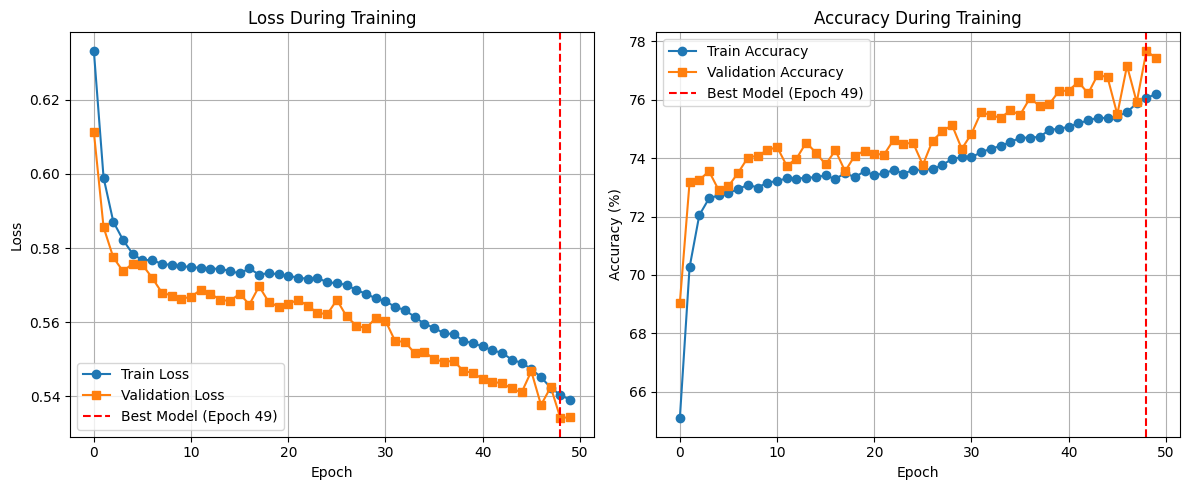

Evaluating pretrained policy for 20 episodes...
Combustion problem initialized with T=600.0, P=101325.0, phi=0.7 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 4429.01it/s]

Reference solution computed in 0.11 seconds


Episode 1: Reward = 423.28, Steps = 499
Combustion problem initialized with T=700.0, P=101325.0, phi=0.8999999999999999 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 11093.11it/s]

Reference solution computed in 0.05 seconds


Episode 2: Reward = 421.11, Steps = 499
Combustion problem initialized with T=800.0, P=101325.0, phi=0.7 and timestep=0.001


Computing reference solution: 100%|██████████| 50/50 [00:00<00:00, 7547.24it/s]


Reference solution computed in 0.01 seconds
Episode 3: Reward = 39.64, Steps = 49
Combustion problem initialized with T=500.0, P=101325.0, phi=0.5 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 11681.93it/s]

Reference solution computed in 0.04 seconds


Episode 4: Reward = 425.64, Steps = 499
Combustion problem initialized with T=1200.0, P=101325.0, phi=1.1999999999999997 and timestep=1e-05


Computing reference solution: 100%|██████████| 200/200 [00:00<00:00, 7761.62it/s]

Reference solution computed in 0.03 seconds


Episode 5: Reward = 158.54, Steps = 199
Combustion problem initialized with T=1000.0, P=101325.0, phi=0.5 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 8979.73it/s]

Reference solution computed in 0.06 seconds


Episode 6: Reward = 451.93, Steps = 499
Combustion problem initialized with T=600.0, P=101325.0, phi=1.4 and timestep=0.001


Computing reference solution: 100%|██████████| 50/50 [00:00<00:00, 8727.59it/s]


Reference solution computed in 0.01 seconds
Episode 7: Reward = 41.54, Steps = 49
Combustion problem initialized with T=1500.0, P=101325.0, phi=1.0999999999999999 and timestep=1e-06


Computing reference solution: 100%|██████████| 2000/2000 [00:00<00:00, 8977.78it/s]


Reference solution computed in 0.22 seconds
State changed to IGNITION at step 1269
State changed to POSTIGNITION at step 1410
Episode 8: Reward = 607.22, Steps = 1999
Combustion problem initialized with T=500.0, P=101325.0, phi=0.5 and timestep=0.001


Computing reference solution: 100%|██████████| 50/50 [00:00<00:00, 5900.99it/s]

Reference solution computed in 0.01 seconds
Episode 9: Reward = 40.33, Steps = 49
Combustion problem initialized with T=1200.0, P=101325.0, phi=0.7 and timestep=1e-05



Computing reference solution: 100%|██████████| 200/200 [00:00<00:00, 5246.59it/s]


Reference solution computed in 0.04 seconds
Episode 10: Reward = 171.03, Steps = 199
Combustion problem initialized with T=600.0, P=101325.0, phi=1.2999999999999998 and timestep=0.001


Computing reference solution: 100%|██████████| 50/50 [00:00<00:00, 9169.08it/s]


Reference solution computed in 0.01 seconds
Episode 11: Reward = 41.46, Steps = 49
Combustion problem initialized with T=800.0, P=101325.0, phi=0.9999999999999999 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 11151.45it/s]


Reference solution computed in 0.05 seconds
Episode 12: Reward = 424.68, Steps = 499
Combustion problem initialized with T=300.0, P=101325.0, phi=0.7999999999999999 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 12014.55it/s]

Reference solution computed in 0.04 seconds


Episode 13: Reward = 421.70, Steps = 499
Combustion problem initialized with T=1400.0, P=101325.0, phi=1.4999999999999998 and timestep=1e-05


Computing reference solution: 100%|██████████| 200/200 [00:00<00:00, 6030.07it/s]

Reference solution computed in 0.03 seconds


Episode 14: Reward = 121.91, Steps = 199
Combustion problem initialized with T=1500.0, P=101325.0, phi=0.7999999999999999 and timestep=1e-05


Computing reference solution: 100%|██████████| 200/200 [00:00<00:00, 2637.20it/s]

Reference solution computed in 0.08 seconds


State changed to IGNITION at step 97
State changed to POSTIGNITION at step 144
Episode 15: Reward = -196.43, Steps = 199
Combustion problem initialized with T=1400.0, P=101325.0, phi=0.6 and timestep=1e-05


Computing reference solution: 100%|██████████| 200/200 [00:00<00:00, 5766.20it/s]

Reference solution computed in 0.04 seconds


Episode 16: Reward = 113.87, Steps = 199
Combustion problem initialized with T=800.0, P=101325.0, phi=0.6 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 11317.91it/s]

Reference solution computed in 0.05 seconds


Episode 17: Reward = 437.43, Steps = 499
Combustion problem initialized with T=600.0, P=101325.0, phi=1.1999999999999997 and timestep=0.001


Computing reference solution: 100%|██████████| 50/50 [00:00<00:00, 9883.37it/s]


Reference solution computed in 0.01 seconds
Episode 18: Reward = 41.65, Steps = 49
Combustion problem initialized with T=1100.0, P=101325.0, phi=0.5 and timestep=1e-06


Computing reference solution: 100%|██████████| 2000/2000 [00:00<00:00, 12489.61it/s]


Reference solution computed in 0.16 seconds
Episode 19: Reward = 1834.45, Steps = 1999
Combustion problem initialized with T=800.0, P=101325.0, phi=0.9999999999999999 and timestep=0.001


Computing reference solution: 100%|██████████| 50/50 [00:00<00:00, 7900.07it/s]

Reference solution computed in 0.01 seconds
Episode 20: Reward = 40.78, Steps = 49

Evaluation Results:
Mean Reward: 303.09 ± 407.37
Mean Episode Length: 439.0 steps

Overall Action Distribution:
  RK: 61.6%, BDF: 38.4%

Stage-Specific Action Distribution:
  PREIGNITION: RK: 57.6%, BDF: 42.4%
  IGNITION: RK: 100.0%, BDF: 0.0%
  POSTIGNITION: RK: 100.0%, BDF: 0.0%

Integrator Performance Metrics:
  RK: Mean Error: 0.000064, Mean CPU Time: 0.001893s
  BDF: Mean Error: 0.000001, Mean CPU Time: 0.000972s
Evaluation results saved to pretraining_results/eval_stats.npy


Integrator comparison plot saved to pretraining_results/plots/integrator_comparison.png


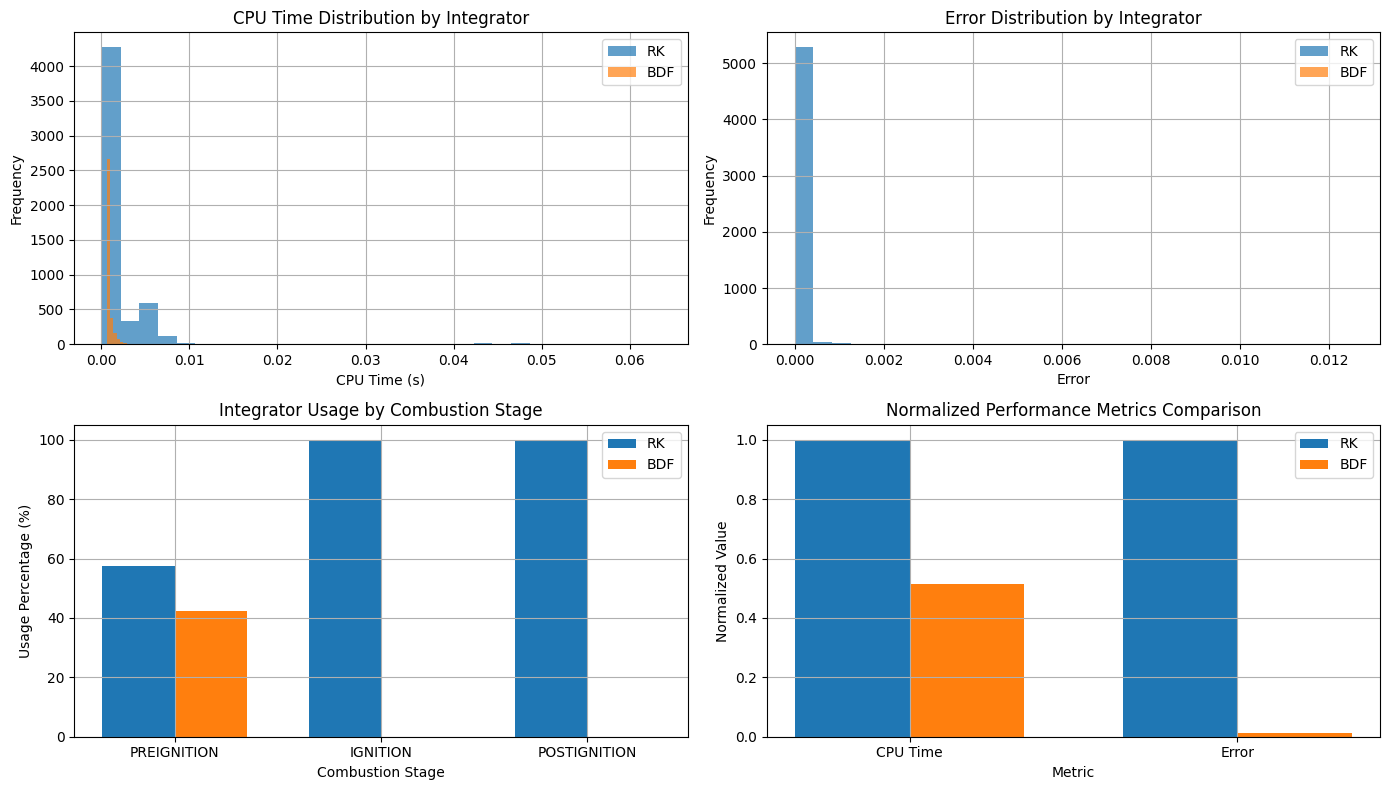

In [218]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class IntegratorDataset(Dataset):
    """Dataset for pretraining the PPO actor with optimal integrator choices."""
    
    def __init__(self, data, obs_dim):
        """
        Initialize dataset from collected optimal integrator data.
        
        Parameters:
        -----------
        data : numpy.ndarray
            Combined history data with structure: [obs, action, reward, error, cpu_time, time_reward, error_reward]
        obs_dim : int
            Dimension of the observation space
        """
        self.data = data
        self.obs_dim = obs_dim
        
        # Extract observations and actions from the combined data
        self.states = data[:, :obs_dim]
        self.actions = data[:, obs_dim].astype(np.int64)  # Extract actions (already 0 or 1)
        
        # Check action distribution
        unique_actions, counts = np.unique(self.actions, return_counts=True)
        total = len(self.actions)
        
        print("Action distribution in dataset:")
        for action, count in zip(unique_actions, counts):
            print(f"  Action {int(action)}: {count} samples ({100 * count / total:.2f}%)")
        
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]


def randomize_dataset(dataset_path, obs_dim, save_path=None):
    """
    Randomize and shuffle the dataset to improve training.
    
    Parameters:
    -----------
    dataset_path : str
        Path to the numpy array containing the pretraining dataset
    obs_dim : int
        Dimension of the observation space
    save_path : str, optional
        Path to save the randomized dataset
        
    Returns:
    --------
    numpy.ndarray
        Randomized dataset
    """
    # Load dataset
    print(f"Loading dataset from {dataset_path}")
    data = np.load(dataset_path)
    print(f"Original dataset shape: {data.shape}")
    
    # Extract actions
    actions = data[:, obs_dim].astype(np.int64)
    unique_actions, counts = np.unique(actions, return_counts=True)
    
    print("\nOriginal action distribution:")
    for action, count in zip(unique_actions, counts):
        print(f"  Action {int(action)}: {count} samples ({100 * count / total:.2f}%)")
    
    # Shuffle the dataset
    randomized_data = shuffle(data, random_state=42)
    
    # Save if path is provided
    if save_path is not None:
        np.save(save_path, randomized_data)
        print(f"Randomized dataset saved to {save_path}")
    
    return randomized_data


def split_dataset(data, obs_dim, test_size=0.2, balance_actions=True, random_state=42):
    """
    Split dataset into training and test sets with optional balancing of actions.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Dataset to split
    obs_dim : int
        Dimension of the observation space
    test_size : float
        Fraction of the dataset to use for testing
    balance_actions : bool
        Whether to ensure similar action distributions in train and test sets
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    numpy.ndarray
        Training dataset
    numpy.ndarray
        Test dataset
    """
    # Extract actions for stratification
    actions = data[:, obs_dim].astype(np.int64)
    
    if balance_actions:
        # Use stratified split to maintain action distribution
        train_indices, test_indices = train_test_split(
            np.arange(len(data)),
            test_size=test_size,
            stratify=actions,
            random_state=random_state
        )
    else:
        # Random split without stratification
        train_indices, test_indices = train_test_split(
            np.arange(len(data)),
            test_size=test_size,
            random_state=random_state
        )
    
    train_data = data[train_indices]
    test_data = data[test_indices]
    
    # Verify action distribution in splits
    train_actions = train_data[:, obs_dim].astype(np.int64)
    test_actions = test_data[:, obs_dim].astype(np.int64)
    
    train_unique, train_counts = np.unique(train_actions, return_counts=True)
    test_unique, test_counts = np.unique(test_actions, return_counts=True)
    
    print("\nAction distribution in train set:")
    for action, count in zip(train_unique, train_counts):
        print(f"  Action {int(action)}: {count} samples ({100 * count / len(train_actions):.2f}%)")
    
    print("\nAction distribution in test set:")
    for action, count in zip(test_unique, test_counts):
        print(f"  Action {int(action)}: {count} samples ({100 * count / len(test_actions):.2f}%)")
    
    print(f"\nTrain set: {len(train_data)} samples ({100 * len(train_data) / len(data):.1f}%)")
    print(f"Test set: {len(test_data)} samples ({100 * len(test_data) / len(data):.1f}%)")
    
    return train_data, test_data


def pretrain_ppo_actor_with_validation(agent, dataset_path, obs_dim, batch_size=64, epochs=20,
                                       learning_rate=1e-4, test_size=0.2, save_path=None, device=None,
                                       patience=5, balance_actions=True):
    """
    Pretrain the PPO actor network with validation and early stopping.
    
    Parameters:
    -----------
    agent : PPO
        The PPO agent with actor network to be pretrained
    dataset_path : str
        Path to the numpy array containing the pretraining dataset
    obs_dim : int
        Dimension of the observation space
    batch_size : int
        Batch size for training
    epochs : int
        Maximum number of epochs to train
    learning_rate : float
        Learning rate for the optimizer
    test_size : float
        Fraction of the dataset to use for testing
    save_path : str, optional
        Path to save the pretrained model (if None, doesn't save)
    device : torch.device, optional
        Device to use for training
    patience : int
        Number of epochs to wait for improvement before early stopping
    balance_actions : bool
        Whether to ensure similar action distributions in train and test sets
        
    Returns:
    --------
    dict
        Training history and metrics
    """
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {device}")
    
    # Load dataset
    print(f"Loading dataset from {dataset_path}")
    data = np.load(dataset_path)
    print(f"Dataset shape: {data.shape}")
    
    # Split into train and test sets
    train_data, test_data = split_dataset(
        data, 
        obs_dim, 
        test_size=test_size, 
        balance_actions=balance_actions
    )
    
    # Create datasets and dataloaders
    train_dataset = IntegratorDataset(train_data, obs_dim)
    test_dataset = IntegratorDataset(test_data, obs_dim)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Extract the actor network from the agent
    actor = agent.policy.actor
    actor.to(device)
    actor.train()
    
    # Setup optimizer and loss function
    optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Training metrics
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    
    # Early stopping variables
    best_test_loss = float('inf')
    best_epoch = 0
    best_state_dict = None
    epochs_no_improve = 0
    
    print(f"Starting pretraining for up to {epochs} epochs with early stopping (patience={patience})")
    for epoch in range(epochs):
        # Training phase
        actor.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for states, actions in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{epochs}", leave=False):
            states = states.float().to(device)
            actions = actions.to(device)
            
            # Forward pass
            action_probs = actor(states)
            loss = criterion(action_probs, actions)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(action_probs.data, 1)
            train_total += actions.size(0)
            train_correct += (predicted == actions).sum().item()
            
            train_loss += loss.item() * states.size(0)  # Weighted by batch size
        
        # Calculate average training metrics
        avg_train_loss = train_loss / train_total
        train_accuracy = 100 * train_correct / train_total
        
        # Validation phase
        actor.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for states, actions in tqdm(test_loader, desc=f"Test Epoch {epoch+1}/{epochs}", leave=False):
                states = states.float().to(device)
                actions = actions.to(device)
                
                # Forward pass
                action_probs = actor(states)
                loss = criterion(action_probs, actions)
                
                # Calculate metrics
                _, predicted = torch.max(action_probs.data, 1)
                test_total += actions.size(0)
                test_correct += (predicted == actions).sum().item()
                
                test_loss += loss.item() * states.size(0)  # Weighted by batch size
        
        # Calculate average validation metrics
        avg_test_loss = test_loss / test_total
        test_accuracy = 100 * test_correct / test_total
        
        # Record history
        train_loss_history.append(avg_train_loss)
        test_loss_history.append(avg_test_loss)
        train_acc_history.append(train_accuracy)
        test_acc_history.append(test_accuracy)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        
        # Check for improvement
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_epoch = epoch
            best_state_dict = actor.state_dict().copy()
            epochs_no_improve = 0
            print(f"  New best model! (Test Loss: {best_test_loss:.4f})")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epochs. Best Test Loss: {best_test_loss:.4f} at epoch {best_epoch+1}")
            
            if epochs_no_improve >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break
    
    # Load best model
    if best_state_dict is not None:
        actor.load_state_dict(best_state_dict)
        print(f"Loaded best model from epoch {best_epoch+1}")
    
    # Save pretrained model if path is provided
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(actor.state_dict(), save_path)
        print(f"Pretrained model saved to {save_path}")
        
        # Also save best model separately
        best_path = os.path.join(os.path.dirname(save_path), 
                                 f"best_{os.path.basename(save_path)}")
        torch.save(best_state_dict, best_path)
        print(f"Best model (epoch {best_epoch+1}) saved to {best_path}")
    
    # Collect all history
    history = {
        'train_loss': train_loss_history,
        'test_loss': test_loss_history,
        'train_acc': train_acc_history,
        'test_acc': test_acc_history,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss,
        'best_test_acc': test_acc_history[best_epoch],
        'epochs_completed': len(train_loss_history)
    }
    
    return history


def plot_training_metrics(history, save_dir=None):
    """
    Plot training and validation metrics.
    
    Parameters:
    -----------
    history : dict
        Training history from pretrain_ppo_actor_with_validation
    save_dir : str, optional
        Directory to save plots
    """
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
    
    # Plot losses
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['test_loss'], label='Validation Loss', marker='s')
    plt.axvline(x=history['best_epoch'], color='r', linestyle='--', 
                label=f'Best Model (Epoch {history["best_epoch"]+1})')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(history['test_acc'], label='Validation Accuracy', marker='s')
    plt.axvline(x=history['best_epoch'], color='r', linestyle='--', 
                label=f'Best Model (Epoch {history["best_epoch"]+1})')
    plt.title('Accuracy During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, 'training_metrics.png'))
        print(f"Training metrics plot saved to {os.path.join(save_dir, 'training_metrics.png')}")
    
    plt.show()


def evaluate_pretrained_policy_detailed(agent, env, num_episodes=10, render=False, 
                                        save_path=None, device=None):
    """
    Evaluate the pretrained policy with detailed metrics.
    
    Parameters:
    -----------
    agent : PPO
        The PPO agent with pretrained actor
    env : gym.Env
        Environment to evaluate in
    num_episodes : int
        Number of episodes to evaluate
    render : bool
        Whether to render the environment
    save_path : str, optional
        Path to save the evaluation results
    device : torch.device, optional
        Device to run evaluation on
        
    Returns:
    --------
    dict
        Evaluation statistics
    """
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Metrics to track
    episode_rewards = []
    episode_lengths = []
    action_distribution = {0: 0, 1: 0}  # 0 for RK, 1 for BDF
    stage_action_dist = {
        'PREIGNITION': {0: 0, 1: 0},
        'IGNITION': {0: 0, 1: 0},
        'POSTIGNITION': {0: 0, 1: 0}
    }
    
    # Track errors and CPU times for each integrator
    integrator_metrics = {
        0: {'errors': [], 'cpu_times': []},
        1: {'errors': [], 'cpu_times': []}
    }
    
    print(f"Evaluating pretrained policy for {num_episodes} episodes...")
    
    for episode in range(num_episodes):
        env = env_manager.create_single_env()
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0
        
        while not done:
            # Use deterministic policy (argmax) for evaluation
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).to(device)
                action = agent.select_action(obs_tensor, deterministic=True, store_in_buffer=False)
            
            # Track action distribution
            action_distribution[action] += 1
            
            # Execute action
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1
            
            # Track stage-specific action choices
            if 'current_stage' in info:
                stage = info['current_stage']
                if stage in stage_action_dist:
                    stage_action_dist[stage][action] += 1
            
            # Track integrator-specific metrics
            if 'error' in info:
                integrator_metrics[action]['errors'].append(info['error'])
            if 'cpu_time' in info:
                integrator_metrics[action]['cpu_times'].append(info['cpu_time'])
            
            if render:
                env.render()
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(steps)
        print(f"Episode {episode+1}: Reward = {episode_reward:.2f}, Steps = {steps}")
    
    # Calculate overall statistics
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    mean_steps = np.mean(episode_lengths)
    
    # Calculate action distribution percentages
    total_actions = sum(action_distribution.values())
    action_percentages = {k: (v / total_actions) * 100 for k, v in action_distribution.items()}
    
    # Calculate stage-specific action percentages
    stage_percentages = {}
    for stage, dist in stage_action_dist.items():
        stage_total = sum(dist.values())
        if stage_total > 0:
            stage_percentages[stage] = {k: (v / stage_total) * 100 for k, v in dist.items()}
        else:
            stage_percentages[stage] = {0: 0, 1: 0}
    
    # Calculate integrator-specific metrics
    for action in integrator_metrics:
        if integrator_metrics[action]['errors']:
            integrator_metrics[action]['mean_error'] = np.mean(integrator_metrics[action]['errors'])
            integrator_metrics[action]['median_error'] = np.median(integrator_metrics[action]['errors'])
        else:
            integrator_metrics[action]['mean_error'] = 0
            integrator_metrics[action]['median_error'] = 0
            
        if integrator_metrics[action]['cpu_times']:
            integrator_metrics[action]['mean_cpu_time'] = np.mean(integrator_metrics[action]['cpu_times'])
            integrator_metrics[action]['median_cpu_time'] = np.median(integrator_metrics[action]['cpu_times'])
        else:
            integrator_metrics[action]['mean_cpu_time'] = 0
            integrator_metrics[action]['median_cpu_time'] = 0
    
    # Compile all statistics
    stats = {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'min_reward': np.min(episode_rewards),
        'max_reward': np.max(episode_rewards),
        'mean_steps': mean_steps,
        'action_distribution': action_distribution,
        'action_percentages': action_percentages,
        'stage_action_dist': stage_action_dist,
        'stage_percentages': stage_percentages,
        'integrator_metrics': integrator_metrics
    }
    
    # Print summary
    print("\nEvaluation Results:")
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"Mean Episode Length: {mean_steps:.1f} steps")
    print(f"\nOverall Action Distribution:")
    print(f"  RK: {action_percentages[0]:.1f}%, BDF: {action_percentages[1]:.1f}%")
    
    print("\nStage-Specific Action Distribution:")
    for stage, percentages in stage_percentages.items():
        if sum(stage_action_dist[stage].values()) > 0:
            print(f"  {stage}: RK: {percentages[0]:.1f}%, BDF: {percentages[1]:.1f}%")
    
    print("\nIntegrator Performance Metrics:")
    for action, metrics in integrator_metrics.items():
        name = "RK" if action == 0 else "BDF"
        if 'mean_error' in metrics:
            print(f"  {name}: Mean Error: {metrics['mean_error']:.6f}, Mean CPU Time: {metrics['mean_cpu_time']:.6f}s")
    
    # Save results if requested
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, stats)
        print(f"Evaluation results saved to {save_path}")
    
    return stats


def compare_integrators(stats, save_path=None):
    """
    Compare performance of different integrators from evaluation statistics.
    
    Parameters:
    -----------
    stats : dict
        Evaluation statistics from evaluate_pretrained_policy_detailed
    save_path : str, optional
        Path to save the comparison plot
    """
    # Extract integrator metrics
    rk_metrics = stats['integrator_metrics'][0]
    bdf_metrics = stats['integrator_metrics'][1]
    
    # Check if we have data for both integrators
    if not (rk_metrics['cpu_times'] and bdf_metrics['cpu_times']):
        print("Insufficient data to compare integrators")
        return
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # CPU Time comparison
    plt.subplot(2, 2, 1)
    plt.hist(rk_metrics['cpu_times'], bins=30, alpha=0.7, label='RK')
    plt.hist(bdf_metrics['cpu_times'], bins=30, alpha=0.7, label='BDF')
    plt.xlabel('CPU Time (s)')
    plt.ylabel('Frequency')
    plt.title('CPU Time Distribution by Integrator')
    plt.legend()
    plt.grid(True)
    
    # Error comparison
    plt.subplot(2, 2, 2)
    plt.hist(rk_metrics['errors'], bins=30, alpha=0.7, label='RK')
    plt.hist(bdf_metrics['errors'], bins=30, alpha=0.7, label='BDF')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution by Integrator')
    plt.legend()
    plt.grid(True)
    
    # Action distribution by stage
    plt.subplot(2, 2, 3)
    stages = list(stats['stage_percentages'].keys())
    rk_percentage = [stats['stage_percentages'][stage][0] for stage in stages]
    bdf_percentage = [stats['stage_percentages'][stage][1] for stage in stages]
    
    x = np.arange(len(stages))
    width = 0.35
    
    plt.bar(x - width/2, rk_percentage, width, label='RK')
    plt.bar(x + width/2, bdf_percentage, width, label='BDF')
    plt.xlabel('Combustion Stage')
    plt.ylabel('Usage Percentage (%)')
    plt.title('Integrator Usage by Combustion Stage')
    plt.xticks(x, stages)
    plt.legend()
    plt.grid(True)
    
    # Overall performance comparison
    plt.subplot(2, 2, 4)
    metrics = ['mean_cpu_time', 'mean_error']
    rk_values = [rk_metrics[m] for m in metrics]
    bdf_values = [bdf_metrics[m] for m in metrics]
    
    # Normalize for comparison
    max_cpu = max(rk_metrics['mean_cpu_time'], bdf_metrics['mean_cpu_time'])
    max_error = max(rk_metrics['mean_error'], bdf_metrics['mean_error'])
    
    rk_normalized = [rk_metrics['mean_cpu_time']/max_cpu, rk_metrics['mean_error']/max_error]
    bdf_normalized = [bdf_metrics['mean_cpu_time']/max_cpu, bdf_metrics['mean_error']/max_error]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, rk_normalized, width, label='RK')
    plt.bar(x + width/2, bdf_normalized, width, label='BDF')
    plt.xlabel('Metric')
    plt.ylabel('Normalized Value')
    plt.title('Normalized Performance Metrics Comparison')
    plt.xticks(x, ['CPU Time', 'Error'])
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Integrator comparison plot saved to {save_path}")
    
    plt.show()


# Example usage:
if __name__ == "__main__":
    from agents.ppo_ import PPO
    from environment.env_wrapper import EnvManager
    import torch
    import os
    
    # Create output directories
    output_dir = "pretraining_results"
    model_dir = os.path.join(output_dir, "models")
    plot_dir = os.path.join(output_dir, "plots")
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)
    
    # Create environment and agent
    env_manager = EnvManager(args)
    env = env_manager.create_single_env()
    
    # Get environment dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Initialize PPO agent
    agent = PPO(
        state_dim=state_dim,
        action_dim=action_dim,
        lr_actor=3e-4,
        lr_critic=3e-4,
        gamma=0.99,
        K_epochs=10,
        eps_clip=0.2,
        has_continuous_action_space=False
    )
    
    # Pretrain the agent
    history = pretrain_ppo_actor_with_validation(
        agent=agent,
        dataset_path='pretraining_dataset_filtered.npy',
        obs_dim=state_dim,
        batch_size=64,
        epochs=50,
        learning_rate=3e-4,
        test_size=0.2,
        patience=7,
        save_path=os.path.join(model_dir, 'pretrained_actor.pth'),
        balance_actions=True
    )
    
    # Plot training metrics
    plot_training_metrics(history, save_dir=plot_dir)
    
    # Evaluate pretrained policy
    eval_stats = evaluate_pretrained_policy_detailed(
        agent=agent,
        env=env,
        num_episodes=20,
        render=False,
        save_path=os.path.join(output_dir, 'eval_stats.npy')
    )
    
    # Compare integrator performance
    compare_integrators(
        stats=eval_stats,
        save_path=os.path.join(plot_dir, 'integrator_comparison.png')
    )

In [217]:
# Evaluate pretrained policy
eval_stats = evaluate_pretrained_policy_detailed(
    agent=agent,
    env=env,
    num_episodes=20,
    render=False,
    save_path=os.path.join(output_dir, 'eval_stats.npy')
)

# Compare integrator performance
compare_integrators(
    stats=eval_stats,
    save_path=os.path.join(plot_dir, 'integrator_comparison.png')
)

Evaluating pretrained policy for 20 episodes...
Episode 1: Reward = 407.22, Steps = 499
Episode 2: Reward = 414.08, Steps = 499
Episode 3: Reward = 413.16, Steps = 499
Episode 4: Reward = 407.53, Steps = 499
Episode 5: Reward = 415.93, Steps = 499
Episode 6: Reward = 418.62, Steps = 499
Episode 7: Reward = 418.59, Steps = 499
Episode 8: Reward = 419.28, Steps = 499
Episode 9: Reward = 417.24, Steps = 499
Episode 10: Reward = 418.97, Steps = 499
Episode 11: Reward = 418.63, Steps = 499
Episode 12: Reward = 413.65, Steps = 499
Episode 13: Reward = 414.19, Steps = 499
Episode 14: Reward = 415.65, Steps = 499
Episode 15: Reward = 418.75, Steps = 499
Episode 16: Reward = 419.38, Steps = 499
Episode 17: Reward = 417.40, Steps = 499
Episode 18: Reward = 418.71, Steps = 499
Episode 19: Reward = 419.35, Steps = 499
Episode 20: Reward = 416.71, Steps = 499

Evaluation Results:
Mean Reward: 416.15 ± 3.54
Mean Episode Length: 499.0 steps

Overall Action Distribution:
  RK: 0.0%, BDF: 100.0%

Stage

In [213]:
from agents.ppo_ import PPO
from environment.env_wrapper import EnvManager
import torch
import matplotlib.pyplot as plt

# Create environment and agent
env_manager = EnvManager(args)
env = env_manager.create_single_env()

# Get environment dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize PPO agent
agent = PPO(
    state_dim=state_dim,
    action_dim=action_dim,
    lr_actor=3e-4,
    lr_critic=3e-4,
    gamma=0.99,
    K_epochs=10,
    eps_clip=0.2,
    has_continuous_action_space=False
)



Combustion problem initialized with T=300.0, P=101325.0, phi=0.8999999999999999 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 10180.15it/s]


Reference solution computed in 0.05 seconds
Environment 0 created with T=300.0, P=101325.0, phi=0.8999999999999999 and timestep=0.0001
Combustion problem initialized with T=900.0, P=101325.0, phi=0.9999999999999999 and timestep=0.0001


Computing reference solution: 100%|██████████| 500/500 [00:00<00:00, 9510.55it/s]

Reference solution computed in 0.05 seconds


In [ ]:
#Pretrain the agent
loss_history = pretrain_ppo_actor(
    agent=agent,
    dataset_path='pretraining_dataset_filtered.npy',
    obs_dim=state_dim,
    batch_size=64,
    epochs=20,
    save_path='pretrained_models/pretrained_actor.pth'
)



Plot saved to pretraining_loss.png


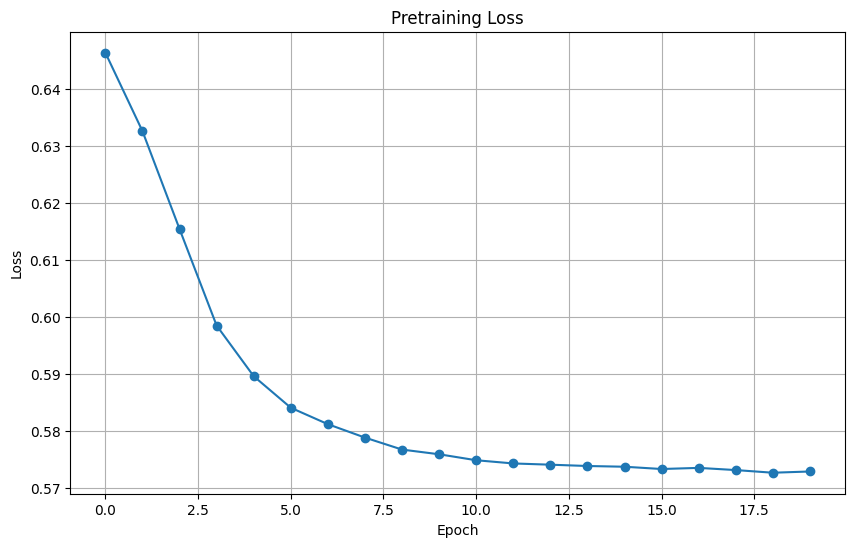

In [215]:
# Plot training results
plot_pretraining_results(loss_history, save_path='pretraining_loss.png')

In [ ]:
# Example usage:
if __name__ == "__main__":
    from agents.ppo_ import PPO
    from environment.env_wrapper import EnvManager
    import torch
    import matplotlib.pyplot as plt
    
    # Create environment and agent
    env_manager = EnvManager(args)
    env = env_manager.create_single_env()
    
    # Get environment dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Initialize PPO agent
    agent = PPO(
        state_dim=state_dim,
        action_dim=action_dim,
        lr_actor=3e-4,
        lr_critic=3e-4,
        gamma=0.99,
        K_epochs=10,
        eps_clip=0.2,
        has_continuous_action_space=False
    )
    
    # Pretrain the agent
    loss_history = pretrain_ppo_actor(
        agent=agent,
        dataset_path='pretraining_dataset.npy',
        obs_dim=state_dim,
        batch_size=64,
        epochs=20,
        save_path='pretrained_models/pretrained_actor.pth'
    )
    
    # Plot training results
    plot_pretraining_results(loss_history, save_path='plots/pretraining_loss.png')
    
    # Evaluate pretrained policy
    eval_stats = evaluate_pretrained_policy(agent, env, num_episodes=10)
    
    # Continue with standard RL training (now with pretrained policy)
    # Create a trainer with the pretrained agent
    trainer = Trainer(args)
    trainer.agent = agent  # Replace with pretrained agent
    trainer.train()